# Kaggle Planet competition with Fast.ai
[The fast.ai course](https://course.fast.ai) is a great way to get started with Deep Learning if you have only some coding experience, but no machine learning experience. Recently, fast.ai decided to switch from Keras to their self-rolled library which is built on top of PyTorch. I can get that decision I think, it's just that so far, the documentation isn't quite equivalent (in the sense that Keras' documentation is excellent, and fast.ai's is... non-existent?).

## Fast.ai by examples
Hence, I figured it would be cool to walk through a Kaggle competition challenge, using the fast.ai library, and dissecting every step. They're mostly notes for myself, but maybe a lost reader might find it useful too.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.model import resnet34
from fastai.dataset import get_cv_idxs, ImageClassifierData
from fastai.transforms import tfms_from_model, transforms_top_down
from fastai.conv_learner import ConvLearner
import torch

# Custom metrics stuff
import numpy as np
import pandas as pd
from sklearn.metrics import fbeta_score
import warnings

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Setting up data ingestion
Fast.ai models expect a data stream to feed them the training samples during training, whatever these samples look like. The fast.ai library offers some pretty handy shortcuts for that.

In [3]:
PATH = "data/amazon/"

The Planet competition provides us with a bunch of images in one folder, and a mapping `.csv` that maps a filename to its classes.

In [4]:
label_csv = f"{PATH}mapping.csv"

## Validation set
If I have to explain what a validation set is or why it is important, it's likely you're a bit in over your head. Probably best if you Google that.
At any rate, the fast.ai library offers a nice shortcut to generate a train/test split called `get_cv_idxs()`, which I'm guessing is short form for *Get Cross-Validation Indexes*. It only requires one argument: the number of total samples available to you.

In [5]:
# Figure out amount of training samples by reading the lines in the mapping
with open(label_csv, 'r') as csv_file:
    number_of_training_samples = sum(1 for row in csv_file)
    # Subtract 1 as this counted the header row of the .csv
    number_of_training_samples -= 1
    
val_idxs = get_cv_idxs(number_of_training_samples)

## Choosing the model
This is chosen to be `resnet34` here, as it's a bit lighter. Of course, any of the other models, like the `resnext` ones etc can be chosen too. What's beautiful about fast.ai is that  it is extremely modular: if you define the model properly, all other functions in the library will automatically adapt to deal with its architecture, input sizes etc.

In [6]:
f_model = resnet34

## Data stream
With the data ingestion set up and the model chosen, we need to create some kind of data stream that will feed the model during training. Effectively, during training, we want to feed the model batches of images. This section is about three things:  
1. Resizing the images correctly
1. Augmenting them if we choose to
1. Creating an object that correctly feeds the model

For those first two, we'll use the `tfms_from_model()` function. For the second part, we'll use the `ImageClassifierData` object.

### Image resizing
A good practice when training a convolutional network is to start out with small images (like 64x64). This allows the convnet to get a first feeling for the images rather quickly and not get sidetracked by details at first. As you progress, you can bump up the image sizes to feed it more details and squeeze out those last few percentages. That's the first two arguments of `tfms_from_model()`: the model that we have chosen, so that we correctly size, and the `sz` argument, which is the image size that we want.

### Data augmentation
For images, data augmentation is a neat trick where you "create" more images that can be used in training by slightly modifying the original ones. The later arguments in `tfms_from_model()` are all about image augmentation. `aug_tfms` is about what kind of transformation you want to do (maybe mirror it, flip it etc). Read the code for more options. max_zoom puts an upper limit on the zooming function used to augment. For more details, I suggest you watch the first class from Fast.ai DL1.  
Note that you can choose to only resize and not augment by not passing along any arguments here. I'm not entirely clear on what kind of images you wouln't want to augment though.

### The output data stream
`ImageClassifierData` is a stream that will output something that `model.fit()` can take in. We need to tell it where to find the training data (first two arguments), where to find the labels (`label_csv` argument), the suffix (because the filenames have `.jpg` while the mapping does not), what transforms to apply (`tfms`), the validation indexes to use, and where the test set is (when we call inference).

In [7]:
def get_data(sz, bs=64):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, "train", label_csv, bs, suffix=".jpg", tfms=tfms,
                                       val_idxs=val_idxs, test_name="test")

### Optional: understanding what comes out of a data loader
Looking at the dimensions probably helps. For `x`: `[torch.FloatTensor of size 64x3x256x256]`  
`256`: the image size that we indicated  
`3`: RGB channels of each image  
`64`: batch size  

`y`: `[torch.FloatTensor of size 64x17]`  
`17`: the amount of distinct classes it found in the `mapping.csv` file  
`64`: batch size  


In [8]:
#(x,y) = next(iter(data.val_dl))
#x
#y

### Custom metrics
The Kaggle planet competition will measured based on F2, so we should do our training based on F2 too. It's a bit more advanced to look at custom metrics, so I'll leave that as an exercise to the reader to go dig into the code. I'll just include the effective lines.

In [8]:
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

metrics=[f2]

## Training the model

### Defining a learner
Training the model involves setting up a so-called "learner". In this case, given we used a fast.ai-supported network, `resnet34`, we can use the `ConvLearner` class. To avoid having to retrain `resnet34` from scratch, we'll also use the `pretrained` property, which returns the network with its pre-trained weights. If this is the first time you run it, it'll first download the pretrained weights and store them in a place it can easily find them again (in the `tmp` directory in your `PATH`).

In [9]:
sz = 256
bs = 64
data = get_data(sz, bs)
learn = ConvLearner.pretrained(f_model, data, metrics=metrics, ps=0.6)

In [31]:
!curl -X POST https://maker.ifttt.com/trigger/jupyter_done/with/key/bC7PnY5XAPTf8fgjJPqjl0

Congratulations! You've fired the jupyter_done event

### Deciding on the learning rate
Again some stuff that's useful with fast.ai: it has a built-in function that helps you in finding the right learning rate through reading a plot. Again, for more details, refer to Lecture 1 of DL1 v2 of the fast.ai classes.

epoch      trn_loss   val_loss   f2                          
    0      0.228463   0.357444   0.795254  



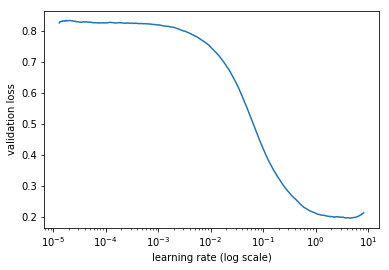

In [21]:
lrf = learn.lr_find()
learn.sched.plot()

In [10]:
lr=0.4
lrs = np.array([lr/9, lr/3, lr])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.freeze()

In [27]:
learn.save(f'{sz}')

In [11]:
learn.load(f'{sz}')

In [ ]:
sz = 128
learn.set_data(get_data(sz))
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.freeze()
learn.save(f'{sz}')

In [23]:
sz = 256
learn.set_data(get_data(sz))
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.freeze()
learn.save(f'{sz}')

epoch      trn_loss   val_loss   f2                          
    0      0.133094   0.114973   0.902654  
    1      0.128123   0.11152    0.904999                    
    2      0.125143   0.108777   0.908218                    
    3      0.12554    0.108833   0.908446                    
    4      0.122794   0.106674   0.908239                    
    5      0.120309   0.105499   0.91096                     
    6      0.11715    0.105262   0.910802                    



epoch      trn_loss   val_loss   f2                          
    0      0.104537   0.090692   0.925343  
    1      0.100349   0.090464   0.922541                     
    2      0.091029   0.085241   0.930068                     
    3      0.099358   0.089241   0.926882                     
    4      0.093725   0.085511   0.931084                     
    5      0.087369   0.08333    0.931182                     
    6      0.086666   0.082431   0.93223                      



In [57]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.freeze()
learn.save(f'{sz}')

epoch      trn_loss   val_loss   f2                          
    0      0.120431   0.100955   0.918047  
    1      0.109882   0.09452    0.922982                    
    2      0.100795   0.088636   0.927518                    
    3      0.106012   0.091146   0.926916                    
    4      0.099447   0.087868   0.927395                     
    5      0.09422    0.08526    0.93036                      
    6      0.093546   0.084552   0.929986                     



# Step plan
1. Set up path to train and test samples
1. Set up validation set using `get_cv_idxs()`
1. Choose model
1. Decide on transforms if applicable
1. Create an *ClassifierData object, either `from csv` or `from file` or whatever the case is
1. Set up the learner, most likely one of the *Learner classes, probably pretrained
1. Train, unfreeze, train more, freeze [optional: bump up image resolution]
1. Set `val_idxs` to [0] in the `get_data()` to include them in training
1. Submit

# Submission

In [30]:
multi_pred, y = learn.TTA(is_test=True)

In [32]:
preds = np.mean(multi_pred, 0)
labels = preds>0.2
labels[:5]

array([[False, False, False, False, False, False, False, False, False, False, False,  True,  True, False,
        False, False, False],
       [False, False, False, False, False,  True, False, False, False, False, False, False,  True, False,
        False, False, False],
       [ True, False, False, False, False,  True, False, False, False,  True, False, False,  True,  True,
        False, False, False],
       [False, False, False, False, False,  True, False, False, False, False, False, False,  True,  True,
         True, False, False],
       [ True, False, False, False, False,  True, False, False, False,  True, False, False,  True,  True,
        False, False,  True]])

In [33]:
subm_df = pd.DataFrame({
    'image_name': [fname[5:-4] for fname in data.test_ds.fnames],
    'tags': [" ".join([data.classes[idx] for idx in row.nonzero()[0].tolist()]) for row in labels]
})

In [34]:
subm_df.head()

,image_name,tags
0,file_9235,partly_cloudy primary
1,file_8058,clear primary
2,test_17915,agriculture clear habitation primary road
3,test_35695,clear primary road selective_logging
4,file_7850,agriculture clear habitation primary road water


In [35]:
subm_df.to_csv(f'subm/amazon-01.gz', compression="gzip", index=False)

In [36]:
!kaggle competitions submit -f subm/amazon-01.gz -m "Maybe names got shuffled?"

Using competition: planet-understanding-the-amazon-from-space
Successfully submitted to Planet: Understanding the Amazon from Space